# Instalación de la librería y carga

In [1]:
!pip install -U git+https://github.com/jdvelasq/techminer 

  Cloning https://github.com/jdvelasq/techminer to /tmp/pip-req-build-cwsrgafl
  Running command git clone -q https://github.com/jdvelasq/techminer /tmp/pip-req-build-cwsrgafl
  Created wheel for techminer: filename=techminer-0.0.0-py3-none-any.whl size=11596879 sha256=b0509c036d5779d8abdb740b8d70d6a410b77d8d9517909dcc16914f1e82ef11
  Stored in directory: /tmp/pip-ephem-wheel-cache-b2uvysln/wheels/aa/18/f7/aa9254dab5830ecf636ab83204c19fb41b997bf4618088120f
Successfully built techminer
  Attempting uninstall: techminer
    Found existing installation: techminer 0.0.0
    Uninstalling techminer-0.0.0:
      Successfully uninstalled techminer-0.0.0


In [2]:
import techminer

# Carga y preparación de datos

In [3]:
# Carga los datos bibliográficos
rdf = techminer.load_dynacol().data
rdf.index = range(len(rdf))
rdf = techminer.nan2none(rdf)
rdf.columns.tolist()

['Abstract',
 'Affiliations',
 'Author Keywords',
 'Author(s) ID',
 'Authors',
 'Cited by',
 'Issue',
 'Language of Original Document',
 'Page end',
 'Page start',
 'Title',
 'Volume',
 'Year',
 'References']

In [4]:
# Se copian las palabras clave para facilitar
rdf['Keywords'] = rdf['Author Keywords']

In [5]:
# Número de registros sin palabras clave
len(rdf[rdf["Keywords"].map(lambda x: x is None)])

33

In [6]:
# Número de abstracts vacios
len(rdf[rdf["Abstract"].map(lambda x: x is None)])

0

In [7]:
# Número de artículos sin título
len(rdf[rdf["Title"].map(lambda x: x is None)])

0

In [8]:
# Remove el copyright del abstract
import numpy as np

rdf["Abstract"] = rdf["Abstract"].map(
    lambda x: x[0 : x.find("\u00a9")]
    if isinstance(x, str) and x.find("\u00a9") != -1
    else x
)

# Crea la unión del título y del abstract
title_abstract = techminer.merge_fields(rdf["Title"], rdf["Abstract"], new_sep=" ")

# Crea un objeto para manejo de palabras clave
kyw = techminer.Keywords()

# Adiciona las palabras clave de los artículos
kyw.add_keywords(rdf["Keywords"], sep=";")

# Extrae las palabras del titulo y el abstract que concuerdan
# con las palabras claves de los otros artículos
keywords_title_abstract = title_abstract.map(
    lambda x: kyw.extract_from_text(x, sep=";")
)

# Completa las palabras clave para los artículos sin palabras clave
idx = rdf["Keywords"].map(lambda x: x is None)
rdf.loc[idx, "Keywords"] = keywords_title_abstract[idx]

# Verifica el número de artículos sin palabras clave
len(rdf[rdf["Keywords"].map(lambda x: x is None)])

7

In [ ]:
rdf['keywords_title_abs'] = 

In [9]:
# Elimina artículos sin palabras clave
idx = rdf["Keywords"].map(lambda x: x is not None)
rdf = rdf[idx]
len(rdf[rdf["Keywords"].map(lambda x: x is None)])

0

In [10]:
# Borrado de abstracts de procceedings y workshops
conf = techminer.Keywords()
conf.add_keywords(["Conference", "Proceeding", "Workshop", "Congress"])
rdf["CONF"] = rdf["Title"].map(lambda x: True if x in conf else False)


In [11]:
# Documentos con el mismo título
print("Num. records before = ", len(rdf))
rdf = techminer.remove_duplicate_records(rdf, "Title", match_type="fingerprint")
print("Num. records after = ", len(rdf))

Num. records before =  1707
Num. records after =  1705


In [12]:
# Limpieza de palabras clave
th = techminer.text_clustering(rdf['Keywords'], sep=';', transformer=lambda x: x.lower())

# Aplica el diccionario a las palabras clave
rdf["Keywords"] = rdf["Keywords"].map(lambda x: th.apply(x, sep=";"))

# Elimina espacios en blanco
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: ";".join(set([w.strip() for w in x.split(";")]))
)

# Cambia cadenas vacias por None
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: x if x != "" else None
)

In [13]:
rdf["Keywords"] = rdf["Keywords"].map(
    lambda x: x.lower()
)

In [14]:
# Numeración de registros para referencias
rdf = techminer.RecordsDataFrame(rdf).generate_ID()

# 3.2 Analysis

In [15]:
#
# Numero de artículos
#
len(rdf)

1705

In [16]:
#
# Número de autores
#
len(rdf.documents_by_terms("Authors", sep=","))

4413

<Figure size 576x864 with 0 Axes>

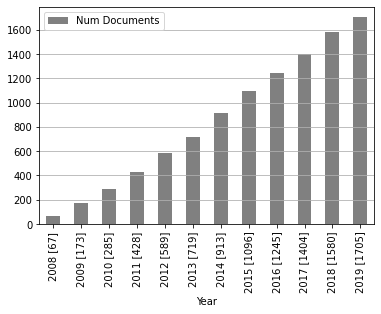

In [17]:
#
# Figure 1. Cumulative number of papers published by year
#
rdf.documents_by_year(cumulative=True).barplot()

In [18]:
#
# Número de paises
#
rdf["Country"] = rdf["Affiliations"].map(lambda x: techminer.extract_country(x, sep=";"))
x = rdf.documents_by_terms("Country", sep=";")
print('Numero de paises = ', len(x))
print()
print(x.head(10))

Numero de paises =  45

         Country  Num Documents  \
0       Colombia           1991   
1          Spain            391   
2         Brazil            276   
3         Mexico            234   
4          Chile             90   
5           Cuba             85   
6  United States             53   
7      Argentina             48   
8       Portugal             43   
9        Ecuador             39   

                                                  ID  
0  [[*0*], [*1*], [*2*], [*3*], [*5*], [*6*], [*7...  
1  [[*4*], [*15*], [*15*], [*19*], [*22*], [*27*]...  
2  [[*4*], [*14*], [*45*], [*50*], [*62*], [*62*]...  
3  [[*33*], [*51*], [*68*], [*96*], [*96*], [*96*...  
4  [[*24*], [*93*], [*192*], [*221*], [*221*], [*...  
5  [[*38*], [*38*], [*56*], [*56*], [*61*], [*62*...  
6  [[*13*], [*33*], [*43*], [*43*], [*51*], [*118...  
7  [[*23*], [*23*], [*23*], [*24*], [*61*], [*234...  
8  [[*330*], [*335*], [*357*], [*357*], [*357*], ...  
9  [[*80*], [*247*], [*289*], [*819*], [

In [19]:
#
# Table 2. Authors with 8 or more documents published in the journal
#
rdf.documents_by_terms("Authors", sep=",", top_n=12)

,Authors,Num Documents,ID
0,Adarme-Jaimes W.,13,"[[*37*], [*1195*], [*1468*], [*1472*], [*1480*..."
1,Correa R.,13,"[[*130*], [*165*], [*308*], [*349*], [*465*], ..."
2,Velásquez J.D.,10,"[[*1105*], [*1316*], [*1317*], [*1322*], [*149..."
3,Arango-Serna M.D.,9,"[[*37*], [*333*], [*850*], [*1056*], [*1219*],..."
4,Rojas-Sola J.I.,9,"[[*32*], [*57*], [*217*], [*315*], [*404*], [*..."
5,Thomson P.,8,"[[*65*], [*469*], [*658*], [*692*], [*723*], [..."
6,Tobón J.I.,8,"[[*476*], [*527*], [*752*], [*830*], [*1132*],..."
7,Palacio C.,8,"[[*11*], [*229*], [*255*], [*307*], [*494*], [..."
8,Saraz J.A.O.,8,"[[*118*], [*182*], [*242*], [*420*], [*535*], ..."
9,García F.,8,"[[*11*], [*107*], [*229*], [*255*], [*288*], [..."


In [20]:
#
# Table 2. Cited by for author in Table 2
#

m = {}
for _, w in rdf[['ID', 'Cited by']].iterrows():
    m[w['ID']] =  w['Cited by']
    
x = rdf.documents_by_terms("Authors", sep=",", top_n=12)
x['Cited by'] = x['ID'].map(lambda s: sum([ m[u] for u in s]))
x

,Authors,Num Documents,ID,Cited by
0,Adarme-Jaimes W.,13,"[[*37*], [*1195*], [*1468*], [*1472*], [*1480*...",64
1,Correa R.,13,"[[*130*], [*165*], [*308*], [*349*], [*465*], ...",28
2,Velásquez J.D.,10,"[[*1105*], [*1316*], [*1317*], [*1322*], [*149...",11
3,Arango-Serna M.D.,9,"[[*37*], [*333*], [*850*], [*1056*], [*1219*],...",27
4,Rojas-Sola J.I.,9,"[[*32*], [*57*], [*217*], [*315*], [*404*], [*...",32
5,Thomson P.,8,"[[*65*], [*469*], [*658*], [*692*], [*723*], [...",36
6,Tobón J.I.,8,"[[*476*], [*527*], [*752*], [*830*], [*1132*],...",28
7,Palacio C.,8,"[[*11*], [*229*], [*255*], [*307*], [*494*], [...",28
8,Saraz J.A.O.,8,"[[*118*], [*182*], [*242*], [*420*], [*535*], ...",41
9,García F.,8,"[[*11*], [*107*], [*229*], [*255*], [*288*], [...",24


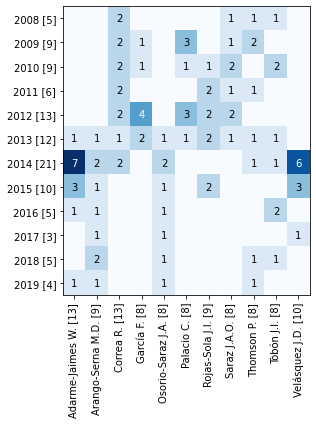

In [21]:
#
# Figure 2. Number of documents by author per year
#
rdf.terms_by_year(column="Authors", sep=",", top_n=11).heatmap(figsize=(4.5, 6))

In [22]:
#
# Number of keywords
# 
len(rdf.documents_by_terms("Keywords", sep=";"))

5705

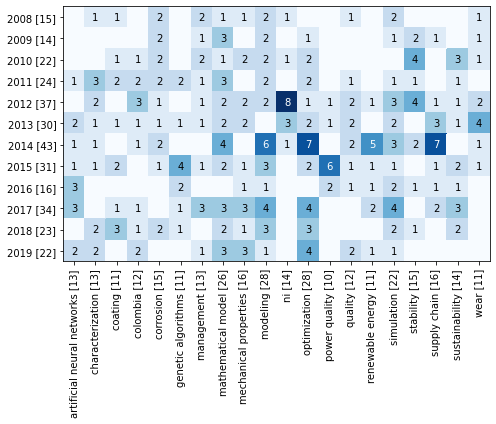

In [23]:
#
# Figure 3. Number of documents by keyword per year
#
rdf.terms_by_year(column="Keywords", sep=";", top_n=20).heatmap(
    figsize=(7, 6)
)

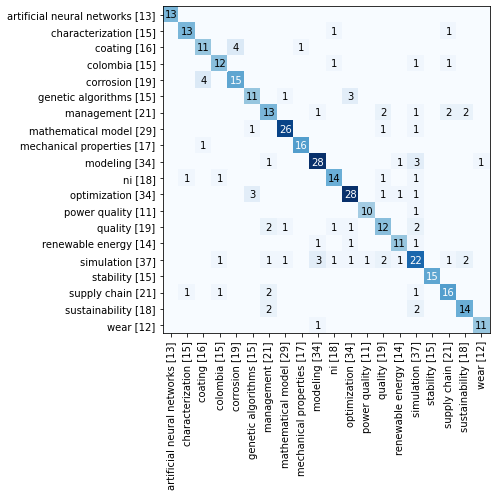

In [24]:
#
# Figure 4. Co-occurrence of keywords used for top 20 authors
#
rdf.ocurrence(column="Keywords", sep=";", top_n=20).heatmap(
    ascending_r=True, ascending_c=True, figsize=(7, 7)
)

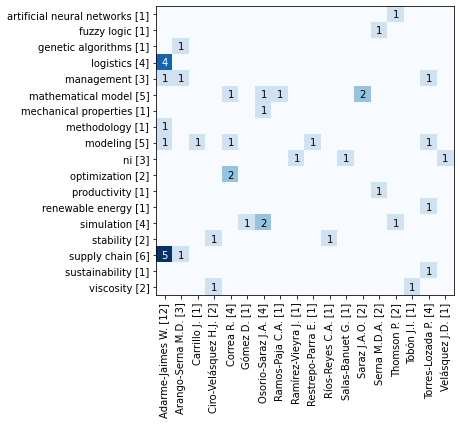

In [25]:
#
# Figure 5. Authors and keywords co-occurrence
#
rdf.co_ocurrence(
    column_r="Authors", column_c="Keywords", sep_r=",", sep_c=";", top_n=30
).heatmap(ascending_r=True, ascending_c=True, figsize=(6.5, 6))

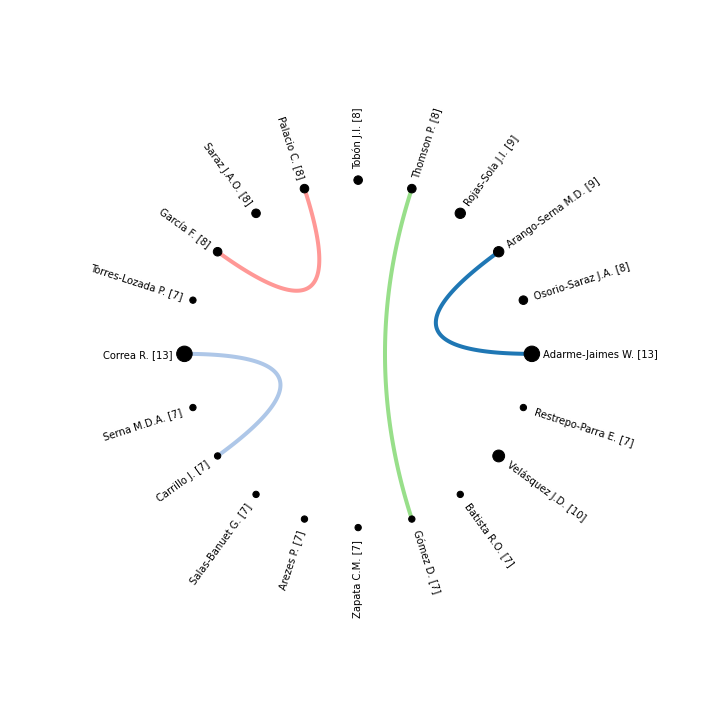

In [26]:
#
# Figure 6. Chord diagram indicating authors who tend to publish together. 
#
rdf.auto_corr(column="Authors", sep=",", top_n=20).chord_diagram(figsize=(10, 10))

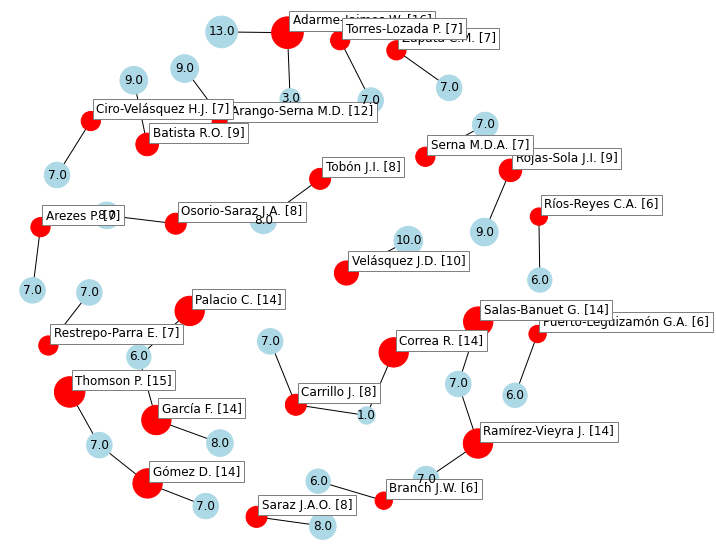

In [27]:
# no usada
rdf.ocurrence(column="Authors", sep=",", top_n=25).ocurrence_map()

In [28]:
#
# Total number of citations
#
rdf['Cited by'].sum()

3792

In [29]:
#
# Number of documents no cited by
#
len(rdf[rdf['Cited by'] == 0])

619

In [30]:
#
# Table 3. Most cited papers
#

t = rdf.most_cited_documents(top_n=10)['Title'].tolist()
a = rdf.most_cited_documents(top_n=10)['Authors'].tolist()
y = rdf.most_cited_documents(top_n=10)['Year'].tolist()
id = rdf.most_cited_documents(top_n=10)['ID'].tolist()

for x in zip(t, a, y, id):
    print(x[0]+'. '+x[1]+'. '+str(x[2])+'.'+x[3])
    print()

Effect of glycerol on the electrical properties and phase behavior of cassava starch biopolymers [Efecto del glicerol sobre las propiedades eléctricas y comportamiento de fase en biopolímeros de almidón de yuca]. Ayala G., Agudelo A., Vargas R.. 2012.[*235*]

Model based predictive control of a rougher flotation circuit considering grade estimation in intermediate cells [Control predictivo de un circuito de flotación rougher considerando estimación de leyes en celdas intermedias]. Rojas D., Cipriano A.. 2011.[*436*]

Markov processes in modeling land use and land cover changes in Sintra-Cascais, Portugal [Procesos de markov en la modelización de alteraciones del uso e ocupación del suelo en Sintra-Cascais, Portugal]. Cabral P., Zamyatin A.. 2009.[*670*]

Major trends in the development of ankle rehabilitation devices [Principales tendencias en el desarrollo de dispositivos de rehabilitacion para tobillo]. Alcocer W., Vela L., Blanco A., Gonzalez J., Oliver M.. 2012.[*174*]

Techniques 

In [31]:
#
# Table 4. Authors with more than 30 citation
#
x = rdf.citations_by_terms('Authors', sep=',', top_n=20)
x['Num Documents'] = x['ID'].map(lambda x: len(x))
x[['Authors', 'Cited by', 'Num Documents']]

,Authors,Cited by,Num Documents
0,Adarme-Jaimes W. [13],64,13
1,García-Alcaraz J.L. [6],52,6
2,Parra E.R. [5],43,5
3,Saraz J.A.O. [8],41,8
4,Gómez D. [7],36,7
5,Thomson P. [8],36,8
6,Manzano-Agugliaro F. [5],35,5
7,Zamyatin A. [3],33,3
8,Cabral P. [3],33,3
9,Rojas H. [5],32,5


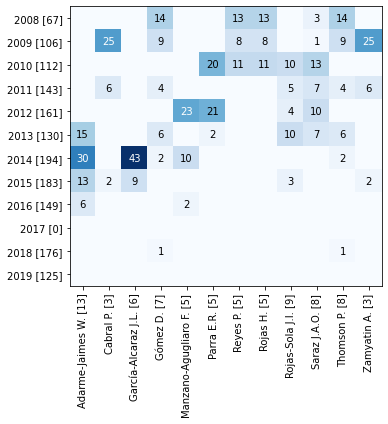

In [32]:
#
# Figure 7. Citations by author per year
#
rdf.citations_by_terms_by_year("Authors", sep=",", top_n=12).heatmap(figsize=(5.5, 6))

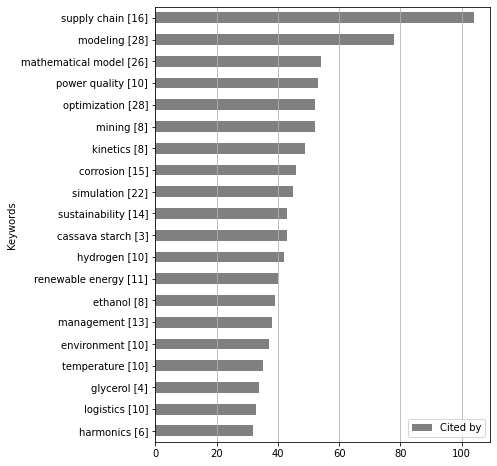

In [33]:
#
# Figure 8. Citations by keyword
#
rdf.citations_by_terms('Keywords', sep=';', top_n=20).barhplot(figsize=(6,8))

# Article clustering

In [34]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

stemmed = rdf.References.apply(
    lambda x:  " ".join([stemmer.stem(w) for w in x.split()]) if isinstance(x, str) else None 
)

stemmed = stemmed[stemmed.map(lambda x: x is not None)]

stemmed.head(30)

ID
[*0*]     (2015) encuesta nacion agropecuaria-ena, , www...
[*1*]     ashkin, a., acceler and trap of particl by rad...
[*2*]     thomas, w.m., nicholas, e.d., needham, j.c., (...
[*3*]     (2015) transport en cifra - estadística 2015, ...
[*4*]     anuário estatístico, , http://www.conab.br, co...
[*5*]     ando, k., kostner, a., neuman, s.p., stochast ...
[*6*]     sejdic, e., djurovic, i., jiang, j., time-freq...
[*7*]     (1987) brundtland report, , http://www.are.adm...
[*8*]     mishra, r., mahoney, m., friction stir weld an...
[*9*]     blanzieri, e., bryl, a., A survey of learning-...
[*10*]    lowell, s., shields, j.e., thomas, m.a., thomm...
[*11*]    muhammetoglu, a., yalcin, o.b., ozcan, t., pre...
[*12*]    makridakis, s.g., forecasting: it role and val...
[*13*]    sanchez-diaz, i., (2012) asses the role of acc...
[*14*]    berry, j., (2018) bulk up: the 2013 colloquy l...
[*15*]    (2001) guidelin On occup safeti and health man...
[*16*]    shirley, d.j., hampton, l.d

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=False,            # Los valores distintos de cero son fijados en 1
    min_df=1                # ignora palabras con baja freq
)

dtm = count_vect.fit_transform(stemmed)
dtm.shape

(1691, 92979)

In [36]:
from sklearn.cluster import KMeans
from sklearn import metrics

result = []


for k in range(2, 30):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(dtm)
    labels = kmeans_model.labels_
    result.append(metrics.silhouette_score(dtm, labels, metric='euclidean'))
    print(k, ' - ', result[-1])

2  -  0.28956497816931975
3  -  0.2736334205836754
4  -  0.1593581204388621
5  -  0.14670880015862833
6  -  0.13641968023731463
7  -  0.012462472505769614
8  -  0.027636563021298664
9  -  -0.01193923629545444
10  -  0.003882191103809018
11  -  0.0693753784949228
12  -  0.02367396728771113
13  -  0.02540804753759561
14  -  0.04122463723992041
15  -  0.03612943730398459
16  -  0.052185542872675586
17  -  -0.05433774392185517
18  -  -0.052755280165764806
19  -  -0.053353654806720406
20  -  -0.01059340204455109
21  -  0.0226692542896205
22  -  0.022046723660354553
23  -  0.01841981835817981
24  -  0.019148906311419606
25  -  0.006272381265971479
26  -  0.00560075057265361
27  -  0.010553547916284697
28  -  0.01564209727268667
29  -  0.015992302887499317


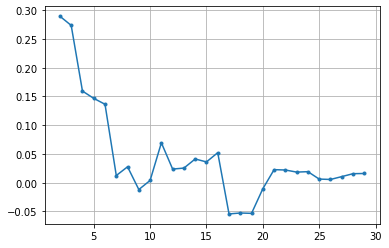

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(2,30), result, '.-')
plt.grid()

In [56]:
CLUSTERS = 7
kmeans_model = KMeans(n_clusters=CLUSTERS, random_state=1).fit(dtm)

In [57]:
rdf['cluster'] = None

In [58]:
for pos, idx in enumerate(stemmed.index.tolist()):
    rdf.at[idx, 'cluster'] = kmeans_model.labels_[pos]

In [59]:
for i in range(CLUSTERS):
    print(len(rdf[rdf.cluster == i]))

615
107
54
20
269
32
594


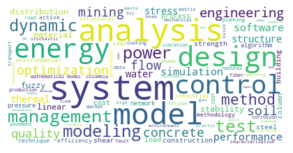

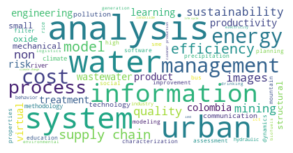

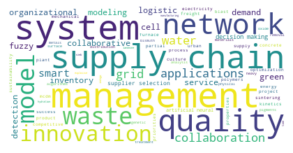

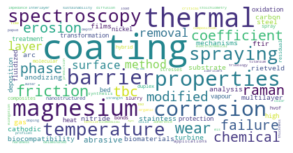

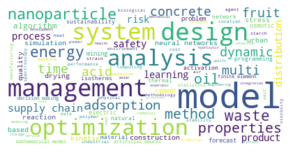

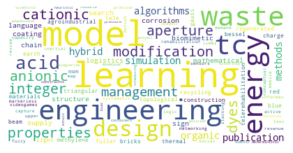

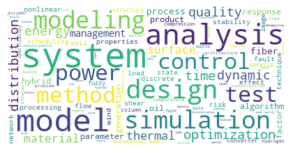

In [64]:
for i in range(CLUSTERS):
    techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).documents_by_terms('Keywords').wordcloud(figsize=(5, 5))

In [71]:
for i in range(CLUSTERS):
    print(techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).most_cited_documents(top_n=15)['Title'])
    print('----')

ID
[*723*]     Control systems for dynamic loading protection...
[*434*]     Vertical well pressure and pressure derivative...
[*741*]     Hydrogenation of furfural on Ir/Nb2O5 catalyst...
[*350*]     A methodological model to assist in the optimi...
[*783*]     Lean management implementation in mining indus...
[*720*]     Kynetic study of the biomass devolatilization ...
[*1665*]    Literature review methodology for scientific a...
[*627*]     Design of a biofilter to reduce the contaminat...
[*1593*]    Chemical-mineralogical characterization of cop...
[*661*]     Analysis and design of experiments applied to ...
[*525*]     Modeling of direct solar radiation in a compou...
[*681*]     Acoustic map making methodology as a tool for ...
[*503*]     Bibliometric analysis of colombian scientific ...
[*535*]     Sugarcane bagasse ash as a partial-port-land-c...
[*716*]     Analysis of turing instability in biological m...
Name: Title, dtype: object
----
ID
[*1530*]    Characterization of 

In [ ]:
# Crea la unión del título y del abstract
title_abs = techminer.merge_fields(rdf["Title"], rdf["Abstract"], new_sep=" ")
keywords_title_abs = techminer.merge_fields(title_abs, rdf["Keywords"], new_sep=" ")

# Crea un objeto para manejo de palabras clave
kyw = techminer.Keywords()

# Adiciona las palabras clave de los artículos
kyw.add_keywords(rdf["Keywords"], sep=";")

# Extrae las palabras del titulo y el abstract que concuerdan
# con las palabras claves de los otros artículos
aug_keywords = keywords_title_abs.map(
    lambda x: kyw.extract_from_text(x, sep=";")
)

# Clustering basado en journal de la referencia

In [348]:
refs = rdf.References
refs = refs.map(lambda x: x.split(';') if x is not None else x)
refs = refs.map(lambda x: [w[0:w.find('http')+1] if 'http' in w else w for w in x] if x is not None else x)
refs = refs.map(lambda x: [w for w in x if ' pp. ' in w] if x is not None else x)
refs = refs.map(lambda x: [w[-100:] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find('('):] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w for w in x if len(w) > 22] if x is not None else x)
refs = refs.map(lambda x: [w[1:] if len(w) > 90 else w   for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find('('):] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[1:] if len(w) > 2 and not w[1].isdigit() else w for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find('('):] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w for w in x if len(w) > 20] if x is not None else x)
refs = refs.map(lambda x: [w.lower() for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[w.find(')')+2:] for w in x] if x is not None else x)
refs = refs.map(lambda x: [w[:w.find(',')] for w in x] if x is not None else x)

In [349]:
refs[1155]

['decision support systems',
 'computers and electronics in agriculture',
 'journal of agricultural engineering research',
 'biomass and bioenergy',
 'bioresource technology',
 'computers and electronics in agriculture',
 'applied energy',
 'biosystem engineering special issue: operations management',
 'proc. s. afr. sug. technol. ass.',
 'proc. s. afr. sug. technol. ass.',
 'south african',
 'computers and electronics in agriculture',
 'agricultural systems',
 'computer and electronics in agriculture',
 'arpn journal of agricultural and biological science',
 'agricultural systems',
 'computers and electronics in agriculture',
 'proc. s. afr. sug. technol. ass.',
 'proceedings of the 2010 winter simulation conference',
 'computer and electronics in agriculture',
 'ingeniería y competitividad',
 'computers and electronics in agriculture',
 'applied mathematical modelling']

In [350]:
source_list = set()
for ref in refs:
    if ref is not None:
        for w in ref:
            source_list.add(w)

In [351]:
len(source_list)

10308

In [359]:
import pandas as pd

dtm = pd.DataFrame()
for source in source_list:
    dtm[source] = [0] * len(refs)

In [360]:
len(dtm)

1705

In [361]:
for idx, ref in enumerate(refs):
    if ref is not None:
        for w in ref:
            dtm.at[idx, w] = 1

In [362]:
dtm.sum().sum()

18581

In [363]:
max(dtm.sum())

483

In [364]:
len(dtm.columns)

10308

In [366]:
import networkx as nx

plt.figure(figsize=(8, 8))
graph = nx.Graph()
nodes = list(range(len(dtm)))
graph.add_nodes_from(nodes)


for icol in dtm.columns:
    
    rows = dtm[icol][dtm[icol] > 0].index.tolist()
    for i in rows:
        for j in rows:
            if j > i:
                graph.add_edge(i, j)
    

path_length = nx.shortest_path_length(graph)
distances = pd.DataFrame(index=graph.nodes(), columns=graph.nodes())
for row, data in path_length:
    for col, dist in data.items():
        distances.loc[row,col] = dist
distances = distances.fillna(distances.max().max())
layout = nx.kamada_kawai_layout(graph, dist=distances.to_dict())

<Figure size 576x576 with 0 Axes>

(-1.0013793527582318,
 1.0953037787027728,
 -0.6506767469159874,
 1.0503983231774692)

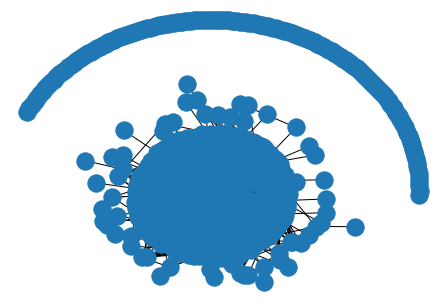

In [367]:
nx.draw(
    graph, 
    layout, 
)
plt.axis('off')

2  -  0.4524854942580327
3  -  0.06826680256076562
4  -  0.06961613798795803
5  -  0.0710373191639295
6  -  0.17085191567127023
7  -  0.15225220830552538
8  -  0.25632745308398414
9  -  0.2569241805608473
10  -  0.25839229175623957
11  -  0.21850369373312387
12  -  0.22251179783029434
13  -  0.22536887838683342
14  -  0.2259701967871661


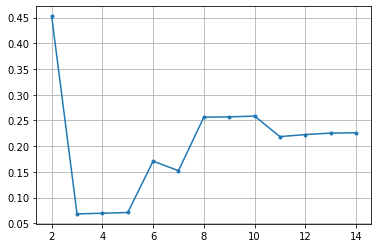

In [333]:
result = []
for k in range(2, 15):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(dtm)
    labels = kmeans_model.labels_
    result.append(metrics.silhouette_score(dtm, labels, metric='euclidean'))
    print(k, ' - ', result[-1])
    
plt.plot(range(2,15), result, '.-')
plt.grid()

1208
480
3


ID
[*235*]     Effect of glycerol on the electrical propertie...
[*436*]     Model based predictive control of a rougher fl...
[*670*]     Markov processes in modeling land use and land...
[*1640*]    Techniques to correct and prevent acid mine dr...
[*534*]     XPS structure analysis of TiN/TiC bilayers pro...
[*198*]     Application of a low cost commercial robot in ...
[*178*]     Physical-chemical properties of bismuth and bi...
[*1639*]    Effects of regional infrastructure and offered...
[*312*]     Power quality research techniques: Advantages ...
[*1379*]    The impact of supply voltage distortion on the...
[*223*]     Electricity generation and wind potential asse...
[*1330*]    Prediction of take-over time in highly automat...
[*590*]     Corporate social responsibility in the mining ...
[*527*]     Comparative analysis of performance of portlan...
[*37*]      Collaborative inventory in supply chain optimi...
Name: Title, dtype: object
----
ID
[*174*]     Major t

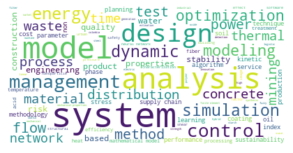

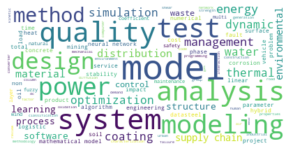

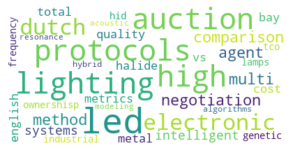

In [335]:
CLUSTERS = 3
kmeans_model = KMeans(n_clusters=CLUSTERS, random_state=1).fit(dtm)

rdf['cluster'] = None
for pos, idx in enumerate(stemmed.index.tolist()):
    rdf.at[idx, 'cluster'] = kmeans_model.labels_[pos]

for i in range(CLUSTERS):
    print(len(rdf[rdf.cluster == i])) 
    
print()
print()
for i in range(CLUSTERS):
    print(techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).most_cited_documents(top_n=15)['Title'])
    print('----')    
    
for i in range(CLUSTERS):
    techminer.dataframe.RecordsDataFrame(rdf[rdf['cluster'] == i]).documents_by_terms('Keywords').wordcloud(figsize=(5, 5))